
# Demo with LangChain
> https://www.freecodecamp.org/news/beginners-guide-to-langchain/

In [ ]:
! pip install openai langchain_core langchain_openai langchain

In [ ]:
#import os
#os.environ["OPENAI_API_KEY"] = ''

In [ ]:
import os
import openai

openai.api_key = os.environ["OPENAI_API_KEY"]

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

chat_model = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"]
)

chat_model.invoke([
    HumanMessage("Hello, how are you today?")
    ])


---
# Prompts

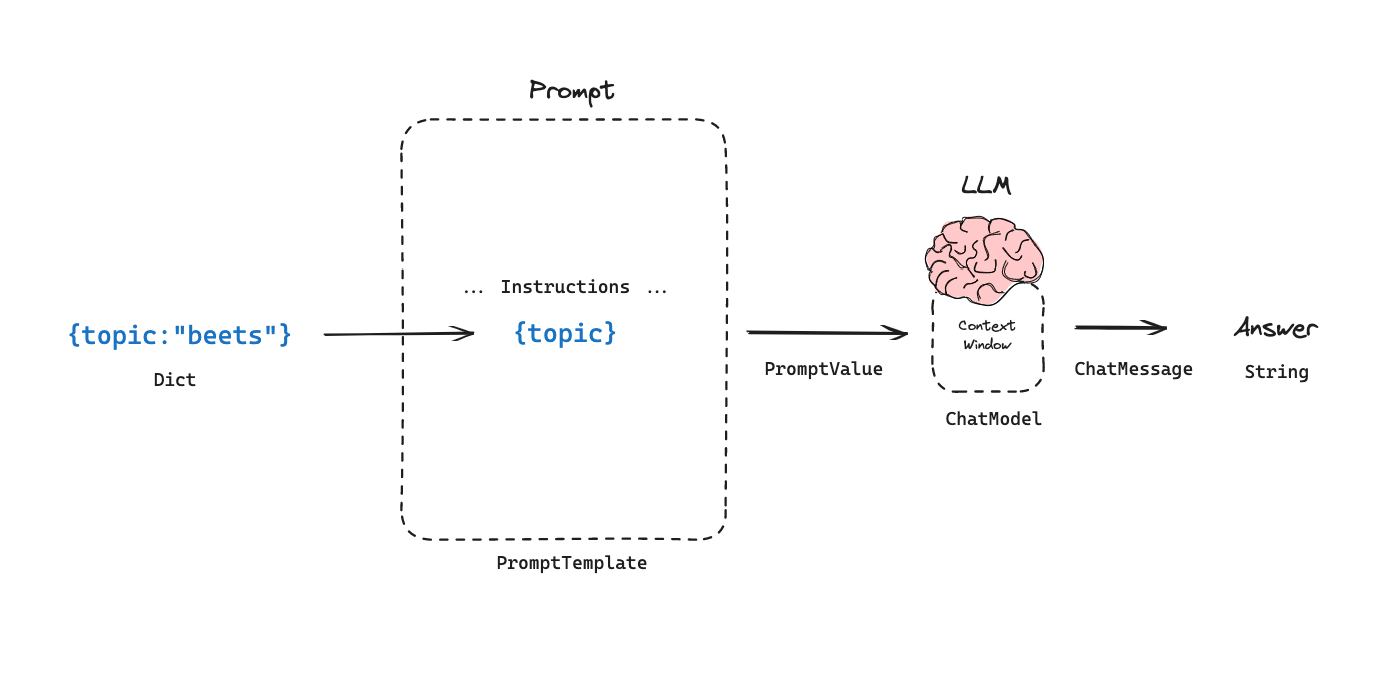

Models are useful on their own, but it’s often convenient to parameterize inputs so that you don’t repeat boilerplate.
LangChain provides `ChatPromptTemplate` for doing this.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

joke_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a world class comedian."),
    ("human", "Tell me a joke about {topic}")
])

joke_prompt.invoke({"topic": "bears"})


You construct a prompt template consisting of:
- templates for a SystemMessage
- a HumanMessage using from_messages.
  
You can think of SystemMessages as meta-instructions that are not part of the current conversation, but purely guide input.

The prompt template contains {topic} in curly braces. This denotes a required parameter named "topic".

You invoke the prompt template with a dict with a key named "topic" and a value "bears".
The result contains the formatted messages.

---
# Chaining

You may have noticed that both the Prompt Template and Chat Model implement theb`.invoke()` method. In LangChain terms, they are both instances of [Runnable Interface](https://python.langchain.com/docs/expression_language/interface/)

You can compose Runnables into “chains” using the pipe (|) operator where you `.invoke()` the next step with the output of the previous one

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

chat_model = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"]
)

joke_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a world class comedian."),
    ("human", "Tell me a joke about {topic}")
])

chain = joke_prompt | chat_model

chain.invoke({"topic": "cars"})

Let's add `StrOutputParser()` to get the output in a string format

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

chat_model = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"]
)

joke_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a world class comedian."),
    ("human", "Tell me a joke about {topic}")
])


chain = joke_prompt | chat_model
# Add output parser to the chain
str_chain = chain | StrOutputParser()

print(str_chain.invoke({"topic": "bears"}))

# Equivalent to:
# str_chain = joke_prompt | chat_model | StrOutputParser()

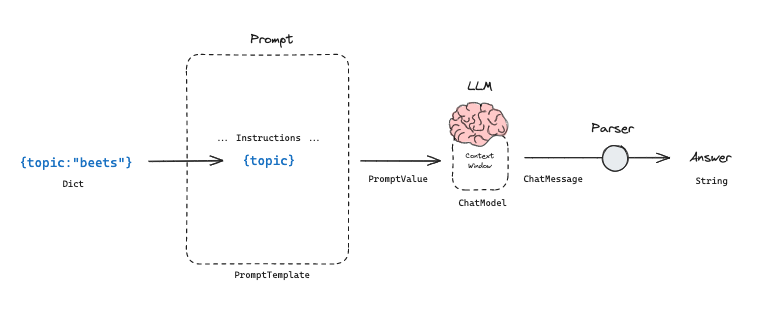

# Streaming

 [Runnables](https://python.langchain.com/docs/expression_language/interface/) implements `.stream()` and `.astream()` (if you’re working in async environments)

Compared to `.invoke()` these methods return a generator that will yield output as soon as it’s available, which allows us to get output as quickly as possible.

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

chat_model = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"]
)

joke_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a world class comedian."),
    ("human", "Tell me a joke about {topic}")
])

chain = joke_prompt | chat_model
str_chain = chain | StrOutputParser()

# str_chain.invoke({"topic": "bears"})

# That is how we can iterate on the streammed chunks
for chunk in str_chain.invoke({"topic": "bears"}):
    print(chunk, end="|")


# Generation with Context

LLMs are trained on large quantities of data and have some innate “knowledge” of various topics. Still, it’s common to pass the model private or more specific data as context when answering to glean useful information or insights. If you've heard the term "RAG", or "retrieval-augmented generation" before, this is the core principle behind it.

One of the simplest examples of this is telling the LLM what the current date is. Because LLMs are snapshots of when they are trained, they can’t natively determine the current time. Here’s an example:

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage


chat_model = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"]
)

chat_model.invoke("what is the current date?")

Now, let’s see what happens when you give the model the current date as context

In [ ]:
from datetime import date
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

chat_model = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"]
)

prompt = ChatPromptTemplate.from_messages([
    ("system", 'You know that the current date is "{current_date}".'),
    ("human", "{question}")
])

chain = prompt | chat_model | StrOutputParser()

chain.invoke({
    "question": "What is the current date?",
    "current_date": date.today()
})

Let's create an example with very specific question and provide a model with the context on the topic

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

chat_model = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"]
)

SOURCE = """
Old Ship Saloon 2023 quarterly revenue numbers:
Q1: $174782.38
Q2: $467372.38
Q3: $474773.38
Q4: $389289.23
"""

rag_prompt = ChatPromptTemplate.from_messages([
    ("system", 'You are a helpful assistant. Use the following context when responding:\n\n{context}.'),
    ("human", "{question}")
])

rag_chain = rag_prompt | chat_model | StrOutputParser()

rag_chain.invoke({
    "question": "What was the Old Ship Saloon's total revenue in Q3 2023?",
    "context": SOURCE
})

# Debugging

Because LLMs are non-deterministic, it becomes more and more important to see the internals of what’s going on as your chains get more complex.

LangChain has a`set_debug(True)` method that will return more granular logs of the chain internals: Let’s see it with the above example.

Here is more in [docs](https://python.langchain.com/docs/guides/development/debugging/)

In [ ]:
from langchain.globals import set_debug

set_debug(True)

chat_model = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"]
)

SOURCE = """
Old Ship Saloon 2023 quarterly revenue numbers:
Q1: $174782.38
Q2: $467372.38
Q3: $474773.38
Q4: $389289.23
"""

rag_prompt = ChatPromptTemplate.from_messages([
    ("system", 'You are a helpful assistant. Use the following context when responding:\n\n{context}.'),
    ("human", "{question}")
])

rag_chain = rag_prompt | chat_model | StrOutputParser()

rag_chain.invoke({
    "question": "What was the Old Ship Saloon's total revenue in Q3 2023?",
    "context": SOURCE
})

In [ ]:
from langchain.globals import set_debug

set_debug(True)

from datetime import date
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

chat_model = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"]
)

prompt = ChatPromptTemplate.from_messages([
    ("system", 'You know that the current date is "{current_date}".'),
    ("human", "{question}")
])

chain = prompt | chat_model | StrOutputParser()

chain.invoke({
    "question": "What is the current date?",
    "current_date": date.today()
})

You can also use the `astream_events()` method to return this data. This is useful if you want to use intermediate steps in your application logic. Note that this is an async method.

In [ ]:
from langchain.globals import set_debug

# Turn off debug mode for clarity
set_debug(False)

from datetime import date
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

chat_model = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"]
)


stream = chain.astream_events({
    "question": "What is the current date?",
    "current_date": date.today()
}, version="v1")

async for event in stream:
    print(event)
    print("-----")